# Requirements

In [ ]:
import random as rnd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


# Data

In [ ]:
capfile = "Capacity.csv"
dayslotfile = "DaysSlots.csv"
regsfile = "R_Data.csv"

#  importing roomsdf CAPACITY
global roomsdf
roomsdf = pd.read_csv(capfile, names=['RoomID', 'Capacity'], dtype=np.int64)
roomsdf


,RoomID,Capacity
0,1,20
1,2,28
2,3,28
3,4,28
4,5,28
5,6,28
6,7,28
7,8,20
8,9,28
9,10,28


In [ ]:
#  importing DAY SLOTS
global slotsdf
slotsdf = pd.read_csv(dayslotfile, dtype=np.int64)
slotsdf


,Day,Slots
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2
5,6,2
6,7,2
7,8,2
8,9,2
9,10,2


In [ ]:
#  importing REGISTRATION data
global regsdf
regsdf = pd.read_csv(regsfile)
regsdf = regsdf.groupby('SID\CID').sum()
regsdf = regsdf.astype(bool)
regsdf


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
SID\CID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1382,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
1383,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
#  STUDENTS
global studentsdf
studentsdf = regsdf.index.to_numpy()
studentsdf


array([   1,    2,    3, ..., 1383, 1384, 1385])

In [ ]:
#  COURSES
global coursesdf
coursesdf = regsdf.columns
coursesdf = np.array(coursesdf, np.int64)
coursesdf


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71])

In [ ]:
totalrooms = roomsdf['RoomID'].size
totalstudents = studentsdf.size
totalslots = slotsdf['Slots'].sum()
totalcourses = coursesdf.size


In [ ]:
# Related to room

def get_room_cap(roomid):
    return roomsdf.loc[roomsdf['RoomID'] == roomid].iloc[0, 1]


def set_room_cap(roomid, capacity):
    roomsdf.loc[roomsdf['RoomID'] == roomid].iloc[0, 1] = capacity


def get_room(index):
    return roomsdf.iloc[index, 0]

# Related to coursesdf


def get_course_students(courseid):
    return regsdf.loc[regsdf[str(courseid)] == True].index


def get_student_courses(studentid):
    lst = regsdf.loc[studentid]
    lst = lst.to_frame()
    return lst[lst[studentid] == True].index.to_numpy(dtype=np.int64)


def student_taking_course(studentid, courseid) -> bool:
    return regsdf.loc[studentid][str(courseid)]


# Representation

## Gene
The chromosome is made up of many genes. In our program we are using course, students, room and slot as our gene. So When these many genes will combine will make a chromosome.

In other words, you can say this is our representation of the genes.

Gene=(course, room, slot, students)

In [ ]:
class Gene:
    def __init__(self, course=None, room=None, slot=None, students=None,):
        # if there are None value then we will use random values
        if course is None:
            course = self.get_rand_course()
        if room is None:
            room = self.get_rand_room()
        if slot is None:
            slot = self.get_rand_slot()
        if students is None:
            students = self.get_rand_students(course, room)

        # copying to the self variables
        self.course = course
        self.room = room
        self.slot = slot
        self.students = students

    def __str__(self) -> str:
        return (
            "Gene[" +
            "course="+str(self.course)+", " +
            "room="+str(self.room)+", " +
            "slot="+str(self.slot)+", " +
            "students="+str(self.students) +
            "]"
        )

    def __repr__(self) -> str:
        return (
            "Gene[" +
            "course="+str(self.course)+", " +
            "room="+str(self.room)+", " +
            "slot="+str(self.slot)+", " +
            "students="+str(len(self.students)) +
            "]"
        )

    def get_rand_course(self):
        return coursesdf[rnd.randint(0, totalcourses-1)]

    def get_rand_room(self):
        return get_room(rnd.randint(0, totalrooms-1))

    def get_rand_slot(self):
        return rnd.randint(1, totalslots)

    def get_rand_students(self, course, room):
        course_studs = get_course_students(course)
        return np.array([course_studs[rnd.randint(0, len(course_studs) - 1)] for _ in range(get_room_cap(room))])


## Chromosome
A array of genes. In our case a chromosome is whole representation of timetabl.

In [ ]:
class Chromosome:
    def __init__(self, genes=None, fitnessval=None, rng=None):
        # filling random values if None
        if rng is None:
            rng = rnd.randint(totalcourses, totalcourses*2)
        if genes is None:
            genes = [Gene() for _ in range(0, rng)]
        if fitnessval is None:
            fitnessval = 0

        self.genes = np.array(genes)
        self.fitnessval = fitnessval
        self.detailfitness = {}

    # for genes list indexing
    def __getitem__(self, index):
        return self.genes[index]

        # for printing
    def __str__(self) -> str:
        return (
            "Chrom[" +
            "Genes="+str(len(self.genes))+", " +
            "Fitness="+str(self.fitnessval) +
            "]"
        )

    def __repr__(self) -> str:
        return self.__str__()

    # length of genes
    def size(self):
        return len(self.genes)

    # # for comparison
    # def __gt__(self, other) -> bool:
    #     return self.fitnessval > other.fitnessval

    # def __lt__(self, other) -> bool:
    #     return self.fitnessval < other.fitnessval

    # Courses of every gene
    def get_courses(self):
        return np.array([gene.course for gene in self.genes])

    def get_slots(self):
        return np.array([gene.slot for gene in self.genes])

    def get_rooms(self):
        return np.array([gene.room for gene in self.genes])

    def get_room_students(self, roomid):
        return np.array([gene.students for gene in self.genes if gene.room == roomid])

    def get_all_students(self):
        return np.concatenate([gene.students for gene in self.genes])

    def get_students_of_course(self, course):
        return np.concatenate([gene.students for gene in self.genes if gene.course == course])


## Population
Population will contains many chromosome and we will apply the genetic algorithm on it

In [ ]:
class Population:
    def __init__(self, chromosomes=None, size=None) -> None:
        # filling random values if None
        if size is None:
            size = 10
        if chromosomes is None:
            chromosomes = [Chromosome() for _ in range(size)]

        self.chromosomes = np.array(chromosomes)

    def __str__(self) -> str:
        return (
            "Population[" +
            "size="+str(len(self.chromosomes))+", " +
            "best=" +
            str(self.get_best())+", " +
            "Chromosomes=\n" +
            "\n".join([str(chrom) for chrom in self.chromosomes]) +
            "]"
        )

    def __repr__(self) -> str:
        return self.__str__()

    def minrepr(self) -> str:
        return (
            "Population[" +
            "size="+str(len(self.chromosomes))+", " +
            "best=" +
            str(self.get_best())+", " +
            "]"
        )

    # for population indexing
    def __getitem__(self, index):
        return self.chromosomes[index]

    def size(self):
        return len(self.chromosomes)

    def get_best(self):
        return max(self.chromosomes, key=lambda chrom: chrom.fitnessval)

    def get_worst(self):
        return min(self.chromosomes, key=lambda chrom: chrom.fitnessval)

    def sort(self, reverse=False):
        self.chromosomes = np.array(sorted(
            self.chromosomes, reverse=reverse, key=lambda chrom: chrom.fitnessval))
        return self


## Representation as a Timetable

In [ ]:
def chromosome_to_df(chromosome):
    table = np.empty((totalrooms, totalslots), dtype=object)

    for course, room, slot in [[gene.course, gene.room, gene.slot] for gene in chromosome]:
        i = room-1
        j = slot-1
        table[i, j] = str(course) if table[i,
                                           j] is None else table[i, j]+", "+str(course)

    table = pd.DataFrame(
        table, columns=np.arange(1, totalslots+1).tolist(), index=np.arange(1, totalrooms+1).tolist())
    table.index.name = "RID/SID"
    return table


# Fitness

## Constraints

### Hard Constraints

In [ ]:
def one_exam_in_one_slot(chromosome):
    '''
    One course exam should be in a slot
    And after that slot or before that slot there should
    be no exam of the course
    More means bad
    '''

    courses = chromosome.get_courses()
    slots = chromosome.get_slots()

    courseslot = np.array([[course, slot]
                           for slot, course in zip(slots, courses)])

    # sorting
    courseslot = courseslot[courseslot[:, 0].argsort()]

    course_slots = np.split(courseslot[:, 1], np.unique(
        courseslot[:, 0], return_index=True)[1][1:])

    # now in course_slots. Course has list of slots in front of we
    # in our case it should be not longer than 1
    # counter the conflicts in which the slots are more than 1

    lst = [len(slots) for slots in course_slots]

    return sum(lst)-len(lst)


def one_room_have_one_exam(chromosome):
    '''
    One room should have one exam at a given time
    Count of the conflicts (more means bad)

    Will be checking the same_slot, same_room. Which means
    that at the given slot the room is beign used twice.
    We are not looking at the course because there should 
    be no duplicated in chromosome for the same room and same slot
    '''

    rooms = chromosome.get_rooms()
    slots = chromosome.get_slots()

    slotroom = [(slot, room) for slot, room in zip(slots, rooms)]

    # unique slot room and there counts
    _, counts = np.unique(slotroom, axis=0, return_counts=True)

    # print(counts)#debugging

    # counting of duplicate exams in one slot and one room
    dups = sum(counts)-len(counts)

    return dups


def student_one_exam_at_a_time(chromosome):
    '''
    At a given time, student can only give one exam

    In this I'll be also checking the duplication of student in the room
    and also in the course. Remeber the course can have multiple rooms within one slot.
    So in short I'll be looking for the same student in the same slot at multiple places

    Counting the conflics, more means bad
    '''

    dupstudents = 0  # duplicates of students in more than one slots
    dupexam = 0  # multiple exam of students at a time

    for i in range(len(chromosome.genes)):
        for student in chromosome.genes[i].students:
            for gene in chromosome:
                if gene == chromosome.genes[i] != gene.slot == chromosome.genes[i].slot:
                    if student in gene.students:  # multiple exam
                        dupexam += 1

        # counting duplicates of student in the same room
        dupstudents += len(chromosome.genes[i].students) - \
            len(set(chromosome.genes[i].students))

    return dupstudents+dupexam


def one_exam_per_course(chromosome):
    ''' 
    Every course should have one exam
    Not two Not zero, only one
    Count of the conflicts (more means bad)
    '''

    courses = chromosome.get_courses()

    uniquecourses, counts = np.unique(courses, return_counts=True)

    # counting the courses which don't have exam
    nocourseexam = totalcourses-len(uniquecourses)

    # counting of courses which have exam more than once
    dupcourseexam = sum(counts)-len(counts)

    return nocourseexam+dupcourseexam


def student_taking_correct_exam(chromosome):
    ''' 
    The Students must take every exam in which they are registered in
    Doesn't Count the number of missing courses for student XXX
    Count the number of missing student in courses
    more count means bad
    '''

    missing_students = 0  # number of students that are missing from exam

    for genes in chromosome:
        correct_sitting = 0
        for student in genes.students:
            stu_courses = get_student_courses(student)
            if genes.course in stu_courses:
                correct_sitting += 1
        missing_students += len(genes.students)-correct_sitting

    return missing_students


def room_cap_enough_for_students(chromosome):
    '''
    Every Gene hae room and student
    In here we will just check that there should be enough
    capacity to hold those students 

    Counting conflicts, more means bad
    '''

    # [(room capacity , number of students)]
    roomcap_students = [(get_room_cap(gene.room), len(gene.students))
                        for gene in chromosome]

    extra_stu = 0  # counting of extra students in room
    empty_space = 0  # counting of empaty space in room

    for cap, stu in roomcap_students:
        if stu > cap:
            extra_stu += stu-cap
        else:
            empty_space += cap-stu

    # extrastudents+(empty spaces)/10 beacause it's not good to have empty rooms
    return extra_stu+empty_space//10


In [ ]:
HARD_CONSTRAINTS = [
    {
        # One course exam should be in a slot
        # And after that slot or before that slot there should
        # be no exam of the course

        "name": "one_exam_in_one_slot",
        "detail": "One course exam should be in a slot",
        "function": one_exam_in_one_slot,
        "weight": 10,
        "bardasht": 10,  # limit after which it's really bad
        "fields": [
            "slot"
        ]
    },
    {
        # rooms to course. The relation is 'n to 1'
        # A course can be in many rooms
        # But a room can only have one Course

        "name": "one_room_have_one_exam",
        "detail": "One room should have only one paper at a time",
        "function": one_room_have_one_exam,
        "weight": 10,
        "bardasht": 10,
        "fields": [
            "room"
        ]
    },
    {
        # A student can't have more than one exam at a time

        "name": "student_one_exam_at_a_time",
        "detail": "One student should have one exam at a time",
        "function": student_one_exam_at_a_time,
        "weight": 1,
        "bardasht": 10,
        "fields": [
            "students",
            # "slot"
        ]
    },
    {
        # Every course should have exam

        "name": "one_exam_per_course",
        "detail": "Every Course should have Exam",
        "function": one_exam_per_course,
        "weight": 10,
        "bardasht": 5,
        "fields": [
            "course"
        ]
    },
    # commenting because of time consumption
    # {
    #     # Every student should have exam of there registered courses

    #     "name": "student_taking_correct_exam",
    #     "detail": "Every Student should have Exam",
    #     "function": student_taking_correct_exam,
    #     "weight": 1,
    #     "bardasht": 10,
    #     "fields": [
    #         "students"
    #     ]
    # },
    {
        "name": "room_cap_enough_for_students",
        "detail": "Rooms should have enough space for the present Course Students",
        "function": room_cap_enough_for_students,
        "bardasht": 10,
        "weight": 1,
        "fields": [
            "room"
        ]
    }
]


### Soft Constraints

## Fitness Calculation

In [ ]:
def cal_fitness(chromosome):
    constraints_scores = []  # scores for the constraint pass
    mutate_fields = []  # field that requires mutation
    tscore = 0

    # Checking Hard Constraints
    for constraint in HARD_CONSTRAINTS:
        conflicts = constraint['function'](chromosome)
        tscore += conflicts*constraint['weight']

        constraints_scores.append({
            "name": constraint['name'],
            "conflicts": conflicts,
            "weight": constraint['weight']
        })

        # filling the fields that requires mutation
        if conflicts > constraint['bardasht'] and constraint['fields'] not in mutate_fields:
            mutate_fields += constraint['fields']

    chromosome.detailfitness = constraints_scores

    # Assigning the calculated fitness to the chromosome
    # range is 0-1. 0 beign the lowest and 1 means the perfect
    actualfitness = 1 / ((1.0*tscore+1))
    chromosome.fitnessval = actualfitness

    return actualfitness, mutate_fields


# Genetic Algorithm

## Selection

In [ ]:
def roulette_wheel(population):
    '''
    Selects the two parents using Roulette Wheel Selection
    '''

    # mom dad
    ama, aba = None, None

    fitness_sum = sum(chrom.fitnessval for chrom in population)

    # running wheel for mom
    rndpick = rnd.uniform(0, fitness_sum)
    endpoint = 0
    for chrom in population:
        endpoint += chrom.fitnessval
        if endpoint >= rndpick:
            ama = chrom
            break

    # running wheel for dad
    rndpick = rnd.uniform(0, fitness_sum)
    endpoint = 0
    for chrom in population:
        endpoint += chrom.fitnessval
        if endpoint >= rndpick:
            aba = chrom
            break

    if ama is None:
        ama = population[rnd.randint(0, population.size()-1)]
    if aba is None:
        aba = population[rnd.randint(0, population.size()-1)]

    return ama, aba


In [ ]:
def elitism(population):
    '''
    Selects the two best parents
    '''

    # mom dad
    ama, aba = None, None

    # assigning best to mom
    ama = population.get_best()

    # assigning second best to mom
    aba = max(population,
              key=lambda chrom: 0 if chrom == ama else chrom.fitnessval)

    if ama is None:
        ama = population[rnd.randint(0, population.size()-1)]
    if aba is None:
        aba = population[rnd.randint(0, population.size()-1)]

    return ama, aba


In [ ]:
def select_best_parents(population):
    # Selects the best mom and dad
    # return roulette_wheel(population) if rnd.randint(0, 1) else elitism(population)
    return elitism(population)


## Crossover

In [ ]:
# husband, wife
def onepoint_crossover(mian, biwi):
    '''
    Single point crossover between two chromosomes.
    Returns the two childs produced
    The childs are two Chromosomes
    '''
    rndpoint = rnd.randint(1, min(mian.size(), biwi.size())-1)

    return (Chromosome(genes=np.concatenate((mian.genes[:rndpoint],
                                             biwi.genes[rndpoint:]))),
            Chromosome(genes=np.concatenate((biwi.genes[:rndpoint],
                                             mian.genes[rndpoint:]))))


In [ ]:
# husband, wife
def crossover(mian, biwi, iter=None):
    '''
    Creates iter*2+2 childs+2parents. All childs will be from same mian biwi.
    This reproduction uses onepoint crossover.
    Returns new numpy array of chromosomes
    '''

    if iter is None:
        iter = rnd.randint(2, 10)

    return np.array(
        [child for _ in range(iter)
         for child in onepoint_crossover(mian, biwi)]+[mian,biwi]
    )


## Mutation

In [ ]:
def alter_gene(gene, mutate_fields):
    '''
    In Alter Gene we are again randomizing the mutation
    We have two choices.
        Make a new Gene and return it.
        Make a new gene and mutate the old gene fields that requires mutation
    '''

    newgene = Gene()

    if rnd.randint(0, 1):  # True, return the new gene
        gene = newgene
    else:  # False, mutate the old gene
        for field in mutate_fields:
            # getting field value from newgene and assigning it to the old gene
            setattr(gene, field, getattr(newgene, field))

    return gene


In [ ]:
def alter_chromosome(chromosome):
    '''
    In Altering Chromosome we have two choices
    Delete some random gene from it
    OR
    Make a whole new Chromosome
    '''

    if rnd.randint(0, 1):  # True, Delete randome gene
        chromosome = np.delete(
            chromosome.genes, rnd.randint(0, chromosome.size()-1))
    else:  # False, Make a new Chromosome
        chromosome = Chromosome()

    return chromosome


In [ ]:
def mutate(chromosome, mutate_fields):
    '''
    Mutating the Chromosome
    Using random to generate True and False,
      if it is True, then alter the gene at the random index
      if False, then alter the whole Chromosome
    '''

    if rnd.randint(0, 1):  # True, alter a gene
        rndidx = rnd.randint(0, chromosome.size()-1)  # picking random index
        chromosome.genes[rndidx] = alter_gene(chromosome.genes[rndidx], mutate_fields)
    else:  # False, alter the chromosome
        chromosome = alter_chromosome(chromosome)

    return chromosome


## Genetic Algorithm

In [ ]:
def GeneticAlgorithm(population=None, iter=None, mutate_prob=None, checkiter=100):
    if iter is None:
        iter = rnd.randint(300, 500)
    if mutate_prob is None:
        mutate_prob = rnd.random()  # [0,1)
    if population is None:
        population = Population(size=10)

    print('========================INITIALIZATION========================')
    print('Max Generations=', iter)
    print('Mutation Probability=', mutate_prob)
    print('Initial Population=', population.minrepr())

    print()

    print('Starting timer......')
    start_time = time.time()

    print('Calculation Fitness......')
    for chrom in population:
        cal_fitness(chrom)

    print('Selecting mom and dad......')
    mom, dad = select_best_parents(population)

    print()

    # time and fitness
    geneticfitness = [(time.time()-start_time, mom.fitnessval)]

    # best
    bestchrom = None

    # Genetic Algorithm loop
    for generation in range(iter):

        # crossover
        childrens = Population(chromosomes=crossover(mom, dad, iter=5))

        # calculating fitness and mutation
        for chrom in childrens:
            _, mutate_fields = cal_fitness(chrom)

            if rnd.random() < mutate_prob:  # mutation
                chrom = mutate(chrom, mutate_fields)

        mom, dad = select_best_parents(childrens)

        current_bestchrom = childrens.get_best()
        if bestchrom is None:
            bestchrom = current_bestchrom
        if bestchrom.fitnessval < current_bestchrom.fitnessval:
            bestchrom = current_bestchrom
        # bestchrom = current_bestchrom = mom

        geneticfitness += [(time.time()-start_time, current_bestchrom.fitnessval)]

        if generation % checkiter == 0:  # printing the values
            print('Generation=', generation)
            print('Current Mom=', mom)
            print('Current Dad=', dad)
            print('Current Best=', current_bestchrom)
            print('Best=', bestchrom)
            print('Time=', geneticfitness[-1])
            print()

    return bestchrom, geneticfitness


## Initialization

In [ ]:
bestsolution, geneticfitness = GeneticAlgorithm(iter=500, checkiter=100)
bestsolution


========================INITIALIZATION========================
Max Generations= 500
Mutation Probability= 0.5521096046190731
Initial Population= Population[size=10, best=Chrom[Genes=87, Fitness=0], ]

Starting timer......
Calculation Fitness......
Selecting mom and dad......

Generation= 0
Current Mom= Chrom[Genes=81, Fitness=0.00027307482250136535]
Current Dad= Chrom[Genes=81, Fitness=0.00026048450117218026]
Current Best= Chrom[Genes=81, Fitness=0.00027307482250136535]
Best= Chrom[Genes=81, Fitness=0.00027307482250136535]
Time= (3.109412908554077, 0.00027307482250136535)

Generation= 100
Current Mom= Chrom[Genes=81, Fitness=0.0002726281352235551]
Current Dad= Chrom[Genes=81, Fitness=0.0002726281352235551]
Current Best= Chrom[Genes=81, Fitness=0.0002726281352235551]
Best= Chrom[Genes=81, Fitness=0.0002832058906825262]
Time= (131.19818258285522, 0.0002726281352235551)

Generation= 200
Current Mom= Chrom[Genes=81, Fitness=0.0002643404705260375]
Current Dad= Chrom[Genes=81, Fitness=0.0002

Chrom[Genes=81, Fitness=0.00029197080291970805]

In [ ]:
bestsolution.detailfitness

[{'conflicts': 28, 'name': 'one_exam_in_one_slot', 'weight': 10},
 {'conflicts': 2, 'name': 'one_room_have_one_exam', 'weight': 10},
 {'conflicts': 2651, 'name': 'student_one_exam_at_a_time', 'weight': 1},
 {'conflicts': 46, 'name': 'one_exam_per_course', 'weight': 10},
 {'conflicts': 13, 'name': 'room_cap_enough_for_students', 'weight': 1}]

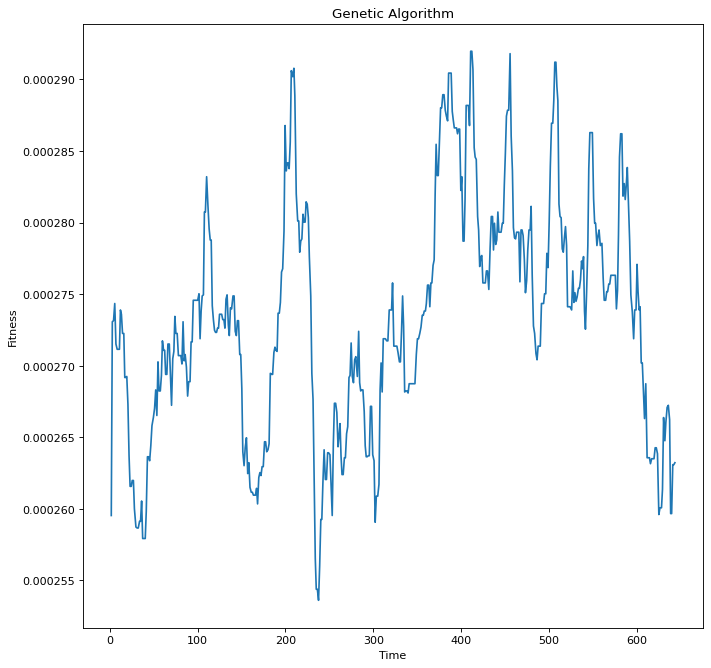

In [ ]:
# printing time vs the fitness for Genetic Algorithm
geneticfitness = np.array(geneticfitness)
plt.figure(figsize=(10, 10), dpi=80)
plt.title("Genetic Algorithm")
plt.xlabel("Time")
plt.ylabel("Fitness")
plt.plot(geneticfitness[:, 0], geneticfitness[:, 1])
plt.show()


In [ ]:
chromosome_to_df(bestsolution)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
RID/SID,,,,,,,,,,,,,,,,,,,,
1,None,None,67,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,22,None,None,None,None
3,None,None,None,None,None,None,None,9,None,None,None,None,None,None,None,None,None,None,None,14
4,None,None,None,None,None,None,None,None,None,18,34,38,None,None,None,None,None,None,None,None
5,None,None,43,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,None,None,None,31,None,None,None,38,None,None,None,None,None,None,None,None,17,None,None,None
8,None,None,None,None,None,None,None,5,None,None,None,None,None,None,None,2,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None,36,None,None,None,None,None,None


# Local Search

## Neighbour Operator

In [ ]:
def oneneighbour(chromosome):
    genez = chromosome.genes
    siz = chromosome.size()
    best = 0
 
    # NS1
    k = rnd.randint(1, siz-1)
    j = rnd.randint(1, siz-1)
    temp = genez[k].slot
    genez[k].slot = genez[j].slot
    genez[j].slot = temp
    temp = genez[k].room
    genez[k].room = genez[j].room
    genez[j].room = temp
    # NS2

    # NS4
    k = rnd.randint(1, siz-1)
    genez[k].slot = np.random.choice(chromosome.get_slots())
    genez[k].room = np.random.choice(chromosome.get_rooms())

    new_chromosome = Chromosome(genez)
    return new_chromosome

In [ ]:
def neighbourhood_operator(chromosome, N=None):
    if N is None:
        N = 10
    
    return [oneneighbour(chromosome) for _ in range(N)]

## Local Search

In [ ]:
def local_search(chromosome=None, N=None, iterator=None):
    if chromosome is None:
        chromosome = Chromosome()
    if N is None:
        N = 10
    if iterator is None:
        iterator = 1000
    best = 0
    start_time = time.time()
    localfitness = [(time.time()-start_time, chromosome.fitnessval)]

    best_chromosome=chromosome

    for i in range(0, iterator):
        new_chromosomes = neighbourhood_operator(best_chromosome, N)

        for chrom in new_chromosomes:
          cal_fitness(chrom)

        nbest_chromosome=max(new_chromosomes, key=lambda chrom:chrom.fitnessval)
        localfitness += [(time.time()-start_time, nbest_chromosome.fitnessval)]

        if nbest_chromosome.fitnessval>=best_chromosome.fitnessval:
            best_chromosome=nbest_chromosome

        if i % 10 == 0:
            print("Iteration=", i)
            print("Current Best", nbest_chromosome)
            print("Best", best_chromosome)
            print()

    return best_chromosome, localfitness


## Initialization

In [ ]:
new_best, localfitness = local_search(iterator=500)
new_best


Iteration= 0
Current Best Chrom[Genes=89, Fitness=0.0002300966405890474]
Best Chrom[Genes=89, Fitness=0.0002300966405890474]

Iteration= 10
Current Best Chrom[Genes=89, Fitness=0.0002187705097352877]
Best Chrom[Genes=89, Fitness=0.0002300966405890474]

Iteration= 20
Current Best Chrom[Genes=89, Fitness=0.00021510002151000216]
Best Chrom[Genes=89, Fitness=0.0002300966405890474]

Iteration= 30
Current Best Chrom[Genes=89, Fitness=0.00021128248468201986]
Best Chrom[Genes=89, Fitness=0.0002300966405890474]

Iteration= 40
Current Best Chrom[Genes=89, Fitness=0.00020470829068577277]
Best Chrom[Genes=89, Fitness=0.0002300966405890474]

Iteration= 50
Current Best Chrom[Genes=89, Fitness=0.0002054653790836244]
Best Chrom[Genes=89, Fitness=0.0002300966405890474]

Iteration= 60
Current Best Chrom[Genes=89, Fitness=0.00020177562550443906]
Best Chrom[Genes=89, Fitness=0.0002300966405890474]

Iteration= 70
Current Best Chrom[Genes=89, Fitness=0.00019976028765481422]
Best Chrom[Genes=89, Fitness=0.00

Chrom[Genes=89, Fitness=0.0002300966405890474]

In [ ]:
new_best.detailfitness


[{'conflicts': 40, 'name': 'one_exam_in_one_slot', 'weight': 10},
 {'conflicts': 6, 'name': 'one_room_have_one_exam', 'weight': 10},
 {'conflicts': 3178, 'name': 'student_one_exam_at_a_time', 'weight': 1},
 {'conflicts': 62, 'name': 'one_exam_per_course', 'weight': 10},
 {'conflicts': 87, 'name': 'room_cap_enough_for_students', 'weight': 1}]

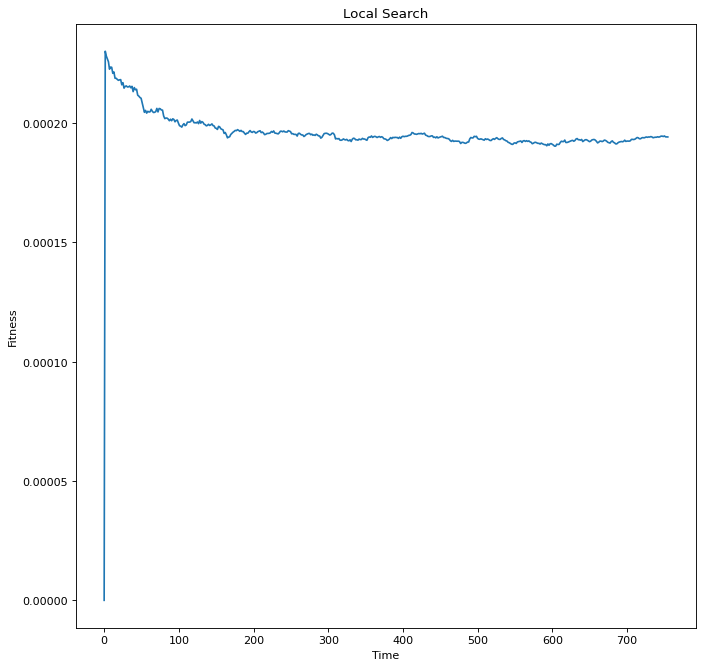

In [ ]:
# printing time vs the fitness for Local Search
localfitness = np.array(localfitness)
plt.figure(figsize=(10, 10), dpi=80)
plt.title("Local Search")
plt.xlabel("Time")
plt.ylabel("Fitness")
plt.plot(localfitness[:, 0], localfitness[:, 1])
plt.show()


# Hybrid

In [85]:
# giving local search the best solution of Genetic Algo
new_best, hybridfitness = local_search(bestsolution, iterator=500)
new_best


Iteration= 0
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fitness=0.00029197080291970805]

Iteration= 10
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fitness=0.00029197080291970805]

Iteration= 20
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fitness=0.00029197080291970805]

Iteration= 30
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fitness=0.00029197080291970805]

Iteration= 40
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fitness=0.00029197080291970805]

Iteration= 50
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fitness=0.00029197080291970805]

Iteration= 60
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fitness=0.00029197080291970805]

Iteration= 70
Current Best Chrom[Genes=81, Fitness=0.00021376656690893543]
Best Chrom[Genes=81, Fi

Chrom[Genes=81, Fitness=0.00029197080291970805]

In [86]:
new_best.detailfitness

[{'conflicts': 28, 'name': 'one_exam_in_one_slot', 'weight': 10},
 {'conflicts': 2, 'name': 'one_room_have_one_exam', 'weight': 10},
 {'conflicts': 2651, 'name': 'student_one_exam_at_a_time', 'weight': 1},
 {'conflicts': 46, 'name': 'one_exam_per_course', 'weight': 10},
 {'conflicts': 13, 'name': 'room_cap_enough_for_students', 'weight': 1}]

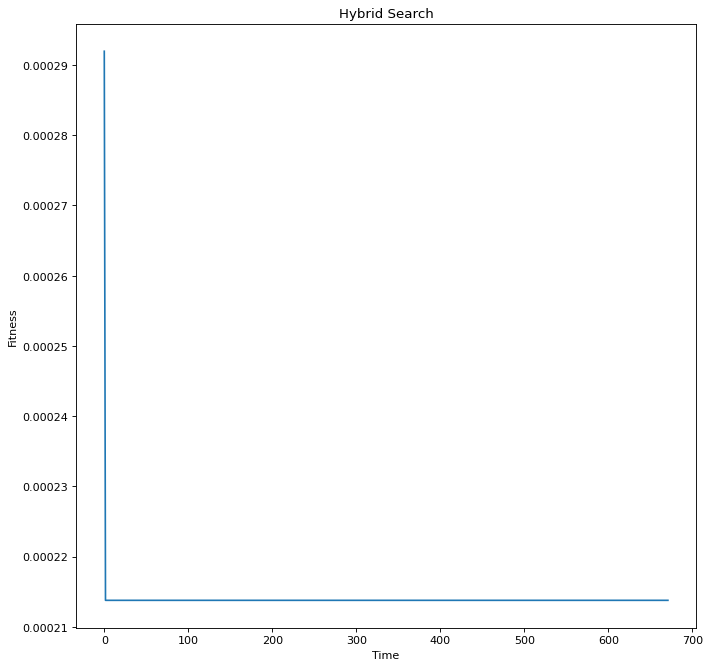

In [87]:
# printing time vs the fitness for Hybrid
hybridfitness = np.array(hybridfitness)
plt.figure(figsize=(10, 10), dpi=80)
plt.title("Hybrid Search")
plt.xlabel("Time")
plt.ylabel("Fitness")
plt.plot(hybridfitness[:, 0], hybridfitness[:, 1])
plt.show()


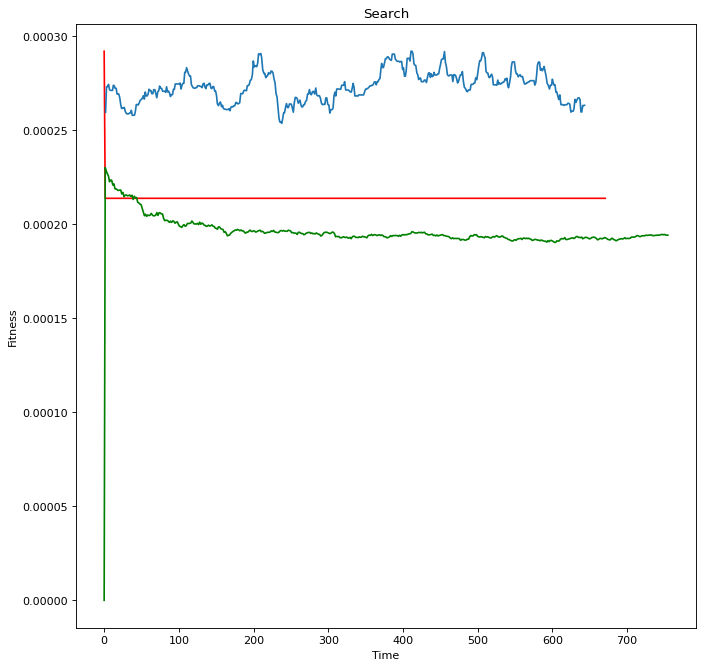

In [88]:
# printing time vs the fitness
plt.figure(figsize=(10, 10), dpi=80)
plt.title("Search")
plt.xlabel("Time")
plt.ylabel("Fitness")
plt.plot(hybridfitness[:, 0], hybridfitness[:, 1],color ="red")
plt.plot(localfitness[:, 0], localfitness[:, 1], color = "green")
plt.plot(geneticfitness[:, 0], geneticfitness[:, 1])
plt.show()
